In [1]:
# Cell - Disable wandb and import libs
import os
os.environ["WANDB_DISABLED"] = "true"  # prevents wandb login prompt
# (set before importing Trainer & HF libs)

import sys
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, set_seed
)

print("torch:", torch.__version__, " CUDA available:", torch.cuda.is_available())
import transformers
print("transformers:", transformers.__version__)
set_seed(42)

torch: 2.8.0+cpu  CUDA available: False
transformers: 4.55.0


In [2]:
# Cell 3 - Load excel (works in Colab or local)
DATA_PATH = "economics_test_items_3000_unique_v8.xlsx"  

if not os.path.exists(DATA_PATH):
    # try Colab file picker
    try:
        from google.colab import files
        print(f"'{DATA_PATH}' not found. Please upload the file now (file picker will appear).")
        uploaded = files.upload()
        # take the first uploaded filename
        DATA_PATH = list(uploaded.keys())[0]
    except Exception:
        raise FileNotFoundError(f"File '{DATA_PATH}' not found in working dir. Place it next to the notebook or upload.")

print("Loading:", DATA_PATH)
df = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Dataset rows:", len(df))
print("Columns:", df.columns.tolist())
display(df.head())

Loading: economics_test_items_3000_unique_v8.xlsx
Dataset rows: 3000
Columns: ['No', 'Question ID', 'Bloom_Level', 'Topic', 'Question_Text', 'Option A', 'Option B', 'Option C', 'Option D', 'Correct Option']


,No,Question ID,Bloom_Level,Topic,Question_Text,Option A,Option B,Option C,Option D,Correct Option
0,1,Q0001,Analyze,Public Finance,Explain how a prolonged drought affecting harv...,It lowers unemployment,Improved export competitiveness,It increases government revenue,It improves competitiveness,B
1,2,Q0002,Understand,International,If Zambia's central bank reduces the policy ra...,It worsens the trade balance,Increase in short-run aggregate demand,It raises interest rates,It reduces supply,B
2,3,Q0003,Create,Money & Banking,Draft a policy mix consisting of three measure...,Only export promotion schemes,cash transfers; technology grants; industrial ...,credit guarantee schemes; skills training and ...,export credit insurance; industrial parks; imp...,D
3,4,Q0004,Evaluate,Micro,Which combination of policies best reduces inf...,Public investment in infrastructure with targe...,It improves productivity,It increases government revenue,It is inflationary,A
4,5,Q0005,Understand,Public Finance,If South Africa's central bank reduces the pol...,It raises interest rates,It reduces aggregate demand,It lowers unemployment,Increase in short-run aggregate demand,D


In [3]:
# Cell 4 - Auto-detect columns (override TEXT_COL / LABEL_COL if needed)
candidates_text = [c for c in df.columns if any(k in c.lower() for k in ["Question_Text", "quest", "stem", "item", "text"])]
candidates_label = [c for c in df.columns if any(k in c.lower() for k in ["Bloom_Level", "level", "taxonomy", "label", "class"])]

TEXT_COL = candidates_text[1] if candidates_text else df.columns[0]
LABEL_COL = candidates_label[0] if candidates_label else df.columns[1] if len(df.columns)>1 else df.columns[0]

print("Using TEXT column:", TEXT_COL)
print("Using LABEL column:", LABEL_COL)
print("Example texts:")
display(df[[TEXT_COL, LABEL_COL]].head())


Using TEXT column: Question_Text
Using LABEL column: Bloom_Level
Example texts:


,Question_Text,Bloom_Level
0,Explain how a prolonged drought affecting harv...,Analyze
1,If Zambia's central bank reduces the policy ra...,Understand
2,Draft a policy mix consisting of three measure...,Create
3,Which combination of policies best reduces inf...,Evaluate
4,If South Africa's central bank reduces the pol...,Understand


In [4]:
# Cell 5 - Normalize label text and map synonyms to canonical Bloom names
def normalize_label(s):
    if pd.isna(s):
        return None
    key = str(s).strip().lower()
    # synonyms map
    synonyms = {
        "remember": "Remember", "recall": "Remember",
        "understand": "Understand", "comprehend": "Understand",
        "apply": "Apply", "application": "Apply",
        "analyse": "Analyze", "analyze": "Analyze", "analysis": "Analyze",
        "evaluate": "Evaluate", "evaluation": "Evaluate",
        "create": "Create", "synthesis": "Create",
        # add any dataset-specific variants you know
    }
    # direct match if exact present in synonyms keys
    if key in synonyms:
        return synonyms[key]
    # some labels might already be in proper form; check canonical names
    canon = ["Remember","Understand","Apply","Analyze","Evaluate", "Create"]
    for c in canon:
        if key == c.lower():
            return c
    # otherwise try partial matches
    for k,v in synonyms.items():
        if k in key:
            return v
    # fallback: return title-cased original
    return str(s).strip().title()

# create normalized label column
df["bloom_norm"] = df[LABEL_COL].apply(normalize_label)
print("Unique normalized labels:", df["bloom_norm"].unique())
# warn about anything unexpected
unexpected = [x for x in df["bloom_norm"].unique() if x not in ["Remember","Understand","Apply","Analyze","Evaluate","Create","None"]]
if unexpected:
    print("WARNING - unexpected label values detected:", unexpected)
display(df[[TEXT_COL, LABEL_COL, "bloom_norm"]].head(8))

Unique normalized labels: ['Analyze' 'Understand' 'Create' 'Evaluate' 'Apply' 'Remember']


,Question_Text,Bloom_Level,bloom_norm
0,Explain how a prolonged drought affecting harv...,Analyze,Analyze
1,If Zambia's central bank reduces the policy ra...,Understand,Understand
2,Draft a policy mix consisting of three measure...,Create,Create
3,Which combination of policies best reduces inf...,Evaluate,Evaluate
4,If South Africa's central bank reduces the pol...,Understand,Understand
5,If nominal GDP rises from 2803 to 4410 while t...,Apply,Apply
6,Which of the following best describes in the ...,Remember,Remember
7,Select the best policy best supports equitable...,Evaluate,Evaluate


In [5]:
# Cell 6 - Define canonical Bloom order (lowest -> highest) and map to integers
bloom_order = ["Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"]
label2id = {lab: i for i, lab in enumerate(bloom_order)}
id2label = {i: lab for lab, i in label2id.items()}

# map to numeric 'label' column, drop rows that could not be mapped
df["label"] = df["bloom_norm"].map(label2id)
missing_map = df["label"].isna().sum()
if missing_map > 0:
    print(f"WARNING: {missing_map} rows could not be mapped to Bloom levels — they will be dropped. Check 'bloom_norm' for unusual values.")
    display(df[df["label"].isna()][[LABEL_COL, "bloom_norm"]].head(10))

df = df.dropna(subset=["label"]).reset_index(drop=True)
df["label"] = df["label"].astype(int)

print("Final label mapping (low->high):", label2id)
print("Counts per mapped label:")
print(df["label"].value_counts().sort_index())

Final label mapping (low->high): {'Remember': 0, 'Understand': 1, 'Apply': 2, 'Analyze': 3, 'Evaluate': 4, 'Create': 5}
Counts per mapped label:
label
0    500
1    500
2    500
3    500
4    500
5    500
Name: count, dtype: int64


In [6]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# def tokenize(batch):
#     return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)

# train_ds = train_ds.map(tokenize, batched=True)
# test_ds = test_ds.map(tokenize, batched=True)

# Cell 7 - Deduplicate & stratified split into train/val/test (80/10/10)

# Drop exact text duplicates first to prevent leakage
df = df.drop_duplicates(subset=[TEXT_COL, "label"]).reset_index(drop=True)
print("After removing duplicates:", len(df))

# Stratified split
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.111111,  # ~10% of original
    stratify=train_val_df["label"],
    random_state=42
)

print("Sizes -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

# Confirm no text overlap
overlap_train_val = set(train_df[TEXT_COL]).intersection(set(val_df[TEXT_COL]))
overlap_train_test = set(train_df[TEXT_COL]).intersection(set(test_df[TEXT_COL]))
overlap_val_test = set(val_df[TEXT_COL]).intersection(set(test_df[TEXT_COL]))

print("Overlap train/val:", len(overlap_train_val))
print("Overlap train/test:", len(overlap_train_test))
print("Overlap val/test:", len(overlap_val_test))



After removing duplicates: 3000
Sizes -> train: 2400 val: 300 test: 300
Overlap train/val: 0
Overlap train/test: 0
Overlap val/test: 0


In [7]:
# Cell 8 - Convert and rename text col -> "text"
train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label"]].rename(columns={TEXT_COL: "text"})).shuffle(seed=42)

dataset_dict = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [8]:
# Cell 9 - Tokenizer and tokenization
MODEL_NAME = "prajjwal1/bert-tiny"  #"distilbert-base-uncased" #"prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

max_length = 128
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=max_length)

tokenized = dataset_dict.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")
tokenized

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [9]:
# Cell 10 - Data collator and model
from transformers import AutoConfig, AutoModelForSequenceClassification, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = len(bloom_order)

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.3,          # Increased from default 0.1
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
#print("Model loaded. num_labels =", num_labels)
print(f"Model loaded with num_labels={num_labels}, dropout={config.hidden_dropout_prob}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with num_labels=6, dropout=0.3


In [10]:
# Cell 11 - Optionally mount Google Drive and set output_dir
SAVE_TO_DRIVE = True   # set False if you don't want to save to Drive

if SAVE_TO_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        output_dir = "/content/drive/MyDrive/hf_bloom_model"
        os.makedirs(output_dir, exist_ok=True)
        print("Model will be saved to Drive:", output_dir)
    except Exception as e:
        print("Could not mount Drive (not in Colab?). Falling back to local folder './hf_bloom_model'")
        output_dir = "./hf_bloom_model"
        os.makedirs(output_dir, exist_ok=True)
else:
    output_dir = "./hf_bloom_model"
    os.makedirs(output_dir, exist_ok=True)


Could not mount Drive (not in Colab?). Falling back to local folder './hf_bloom_model'


In [11]:
# Cell 12 - Training arguments with overfitting prevention
from transformers import TrainingArguments, EarlyStoppingCallback
import torch

training_args = TrainingArguments(
    output_dir=output_dir,
    # Change "evaluation_strategy" to "eval_strategy"
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    fp16=torch.cuda.is_available()
)

print("Training args ready. Output dir:", output_dir)

# Early stopping callback
from transformers import EarlyStoppingCallback
early_stop_callback = EarlyStoppingCallback(early_stopping_patience=2)

print("Training args ready. Output dir:", output_dir)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training args ready. Output dir: ./hf_bloom_model
Training args ready. Output dir: ./hf_bloom_model


In [12]:
# Cell 13 - Metrics function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }

In [13]:

# Cell 14 - Trainer setup
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stop_callback]
)

print("Trainer created.")

trainer.train()

C:\Users\User\AppData\Local\Temp\ipykernel_5624\1243866282.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer created.


C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.710100,1.621237,0.683333,0.754656,0.683333,0.645246
2,1.646100,1.554381,0.690000,0.748362,0.690000,0.655479


C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=600, training_loss=1.713071632385254, metrics={'train_runtime': 53.5052, 'train_samples_per_second': 89.711, 'train_steps_per_second': 11.214, 'total_flos': 453831630624.0, 'train_loss': 1.713071632385254, 'epoch': 2.0})

In [14]:
# - Train (this may take time depending on dataset & GPU)
train_result = trainer.train()
trainer.save_model(output_dir)
print("Training finished, model saved to:", output_dir)
train_result

C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.014400,0.032239,0.993333,0.993590,0.993333,0.993331


C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

KeyboardInterrupt



In [ ]:
# Cell 15 - Evaluate
print("Validation metrics:")
print(trainer.evaluate(tokenized["validation"]))

In [ ]:
print("\nTest metrics:")
print(trainer.evaluate(tokenized["test"]))

In [ ]:
# =======================================
# Evaluation Metrics for Bloom's Taxonomy Prediction
# =======================================
predictions = trainer.predict(tokenized["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Bloom's Taxonomy Classification")
plt.show()


### Testing the trained model on new dataset to predict the Blooms level 

In [18]:
# import pandas as pd
# from transformers import pipeline

# # Path to your Excel file
# file_path = "economics_test_items_300_with_labels.xlsx"  # Adjust if it's in another folder

# # Load your dataset
# df = pd.read_excel(file_path)

# # Assuming the column with the questions is called "Question"
# question_col = "Question"

In [24]:

# ==== 1. Load your new dataset ====
new_data_path = "economics_test_items_300_with_labels.xlsx"
new_df = pd.read_excel(new_data_path)

In [25]:
new_df

,Question_Text,Option A,Option B,Option C,Option D,Correct Option,Bloom_Level
0,"During a 1996 summit, economists in Kenya were...",Irrelevant fact about foreign investment,Incorrect reasoning about foreign investment,Common misconception about foreign investment,Correct answer about foreign investment,D,Understand
1,Identify how taxation could affect small busin...,Incorrect reasoning about taxation,Irrelevant fact about taxation,Correct answer about taxation,Common misconception about taxation,C,Remember
2,"During a 1994 summit, economists in South Afri...",Irrelevant fact about economic planning,Correct answer about economic planning,Common misconception about economic planning,Incorrect reasoning about economic planning,B,Apply
3,"In 1990, the government of Kenya introduced a ...",Irrelevant fact about subsistence farming,Correct answer about subsistence farming,Incorrect reasoning about subsistence farming,Common misconception about subsistence farming,B,Create
4,A firm in Kenya faces challenges due to taxati...,Common misconception about taxation,Correct answer about taxation,Incorrect reasoning about taxation,Irrelevant fact about taxation,B,Create
...,...,...,...,...,...,...,...
295,A chart shows recent changes in fiscal policy ...,Common misconception about fiscal policy,Correct answer about fiscal policy,Irrelevant fact about fiscal policy,Incorrect reasoning about fiscal policy,B,Analyze
296,A chart shows recent changes in economic growt...,Incorrect reasoning about economic growth,Irrelevant fact about economic growth,Common misconception about economic growth,Correct answer about economic growth,D,Analyze
297,A chart shows recent changes in entrepreneursh...,Irrelevant fact about entrepreneurship,Incorrect reasoning about entrepreneurship,Correct answer about entrepreneurship,Common misconception about entrepreneurship,C,Create
298,Differentiate the concept of demand and supply...,Common misconception about demand and supply,Incorrect reasoning about demand and supply,Irrelevant fact about demand and supply,Correct answer about demand and supply,D,Analyze


In [26]:


# ==== 2. Normalize labels (same as training) ====
def normalize_label(s):
    if pd.isna(s):
        return None
    key = str(s).strip().lower()

    mapping = {
        "remembering": "Remember",
        "recall": "Remember",
        "understand": "Understand",
        "comprehension": "Understand",
        "apply": "Apply",
        "application": "Apply",
        "analyze": "Analyze",
        "analysis": "Analyze",
        "evaluate": "Evaluate",
        "evaluation": "Evaluate",
        "creating": "Create",
        "synthesis": "Create",
        "create": "Create",
    }
    return mapping.get(key, s.strip().title())

if "Bloom_Level" in new_df.columns:
    new_df["label"] = new_df["Bloom_Level"].apply(normalize_label)
else:
    # If labels are not provided (for prediction only), just skip this step
    new_df["label"] = None

In [27]:


# ==== 3. Detect question text column ====
candidates_text = [c for c in new_df.columns if any(k in c.lower() for k in ["Question_Text", "stem", "item", "text"])]
TEXT_COL = candidates_text[0] if candidates_text else new_df.columns[0]

# ==== 4. Rename to match training structure ====
# ==== 4. Rename to match training structure (for prediction) ====
predict_ds = Dataset.from_pandas(new_df[[TEXT_COL]].rename(columns={TEXT_COL: "text"}))


In [28]:
## ==== 5. Tokenize with same tokenizer used in training ====
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_predict = predict_ds.map(tokenize, batched=True, remove_columns=["text"])  

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [29]:
# ==== 6. Use trained model to predict ====
predictions = trainer.predict(tokenized_predict)
pred_labels = predictions.predictions.argmax(axis=-1)

C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [30]:
# Map back to Bloom levels
pred_blooms = [id2label[i] for i in pred_labels]
new_df["Predicted_Bloom_Level"] = pred_blooms

In [31]:
new_df

,Question_Text,Option A,Option B,Option C,Option D,Correct Option,Bloom_Level,label,Predicted_Bloom_Level
0,"During a 1996 summit, economists in Kenya were...",Irrelevant fact about foreign investment,Incorrect reasoning about foreign investment,Common misconception about foreign investment,Correct answer about foreign investment,D,Understand,Understand,Analyze
1,Identify how taxation could affect small busin...,Incorrect reasoning about taxation,Irrelevant fact about taxation,Correct answer about taxation,Common misconception about taxation,C,Remember,Remember,Remember
2,"During a 1994 summit, economists in South Afri...",Irrelevant fact about economic planning,Correct answer about economic planning,Common misconception about economic planning,Incorrect reasoning about economic planning,B,Apply,Apply,Analyze
3,"In 1990, the government of Kenya introduced a ...",Irrelevant fact about subsistence farming,Correct answer about subsistence farming,Incorrect reasoning about subsistence farming,Common misconception about subsistence farming,B,Create,Create,Analyze
4,A firm in Kenya faces challenges due to taxati...,Common misconception about taxation,Correct answer about taxation,Incorrect reasoning about taxation,Irrelevant fact about taxation,B,Create,Create,Evaluate
...,...,...,...,...,...,...,...,...,...
295,A chart shows recent changes in fiscal policy ...,Common misconception about fiscal policy,Correct answer about fiscal policy,Irrelevant fact about fiscal policy,Incorrect reasoning about fiscal policy,B,Analyze,Analyze,Evaluate
296,A chart shows recent changes in economic growt...,Incorrect reasoning about economic growth,Irrelevant fact about economic growth,Common misconception about economic growth,Correct answer about economic growth,D,Analyze,Analyze,Evaluate
297,A chart shows recent changes in entrepreneursh...,Irrelevant fact about entrepreneurship,Incorrect reasoning about entrepreneurship,Correct answer about entrepreneurship,Common misconception about entrepreneurship,C,Create,Create,Remember
298,Differentiate the concept of demand and supply...,Common misconception about demand and supply,Incorrect reasoning about demand and supply,Irrelevant fact about demand and supply,Correct answer about demand and supply,D,Analyze,Analyze,Remember


Prediction Accuracy: 0.1700

Classification Report:
              precision    recall  f1-score   support

    Remember       0.21      0.58      0.31        50
  Understand       0.00      0.00      0.00        50
       Apply       0.00      0.00      0.00        50
     Analyze       0.12      0.18      0.14        50
    Evaluate       0.16      0.26      0.20        50
      Create       0.00      0.00      0.00        50

    accuracy                           0.17       300
   macro avg       0.08      0.17      0.11       300
weighted avg       0.08      0.17      0.11       300



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


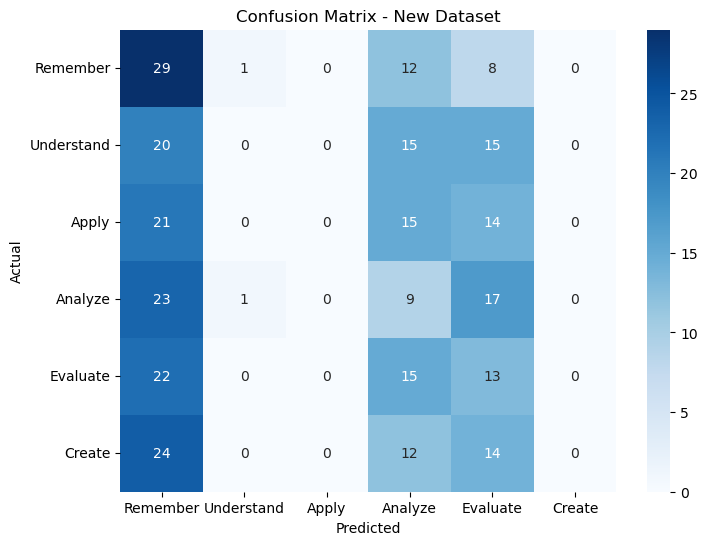

In [32]:
# ==== 6. If actual Bloom labels exist, compute metrics ====
if "Bloom_Level" in new_df.columns:
    # Normalize actual labels (like in training)
    def normalize_label(s):
        if pd.isna(s):
            return None
        key = str(s).strip().lower()
        mapping = {
            "remembering": "Remember", "recall": "Remember",
            "understand": "Understand", "comprehension": "Understand",
            "apply": "Apply", "application": "Apply",
            "analyze": "Analyze", "analysis": "Analyze",
            "evaluate": "Evaluate", "evaluation": "Evaluate",
            "creating": "Create", "synthesis": "Create", "create": "Create"
        }
        return mapping.get(key, s.strip().title())
    
    new_df["Normalized_Actual"] = new_df["Bloom_Level"].apply(normalize_label)
    
    # Accuracy
    acc = accuracy_score(new_df["Normalized_Actual"], new_df["Predicted_Bloom_Level"])
    print(f"Prediction Accuracy: {acc:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(new_df["Normalized_Actual"], new_df["Predicted_Bloom_Level"], labels=bloom_order))
    
    # Confusion Matrix
    cm = confusion_matrix(new_df["Normalized_Actual"], new_df["Predicted_Bloom_Level"], labels=bloom_order)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_order, yticklabels=bloom_order)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - New Dataset")
    plt.show()

In [ ]:


# ==== 7. Save results ====
new_df.to_excel("Economics_300_Predictions.xlsx", index=False)
print("Predictions saved to Economics_300_Predictions.xlsx")

In [19]:


# Load the pipeline from your trained model
clf = pipeline(
    "text-classification", 
    model=output_dir, 
    tokenizer=output_dir, 
    return_all_scores=True
)

def predict_bloom(texts, top_k=1):
    preds = clf(texts)
    results = []
    scores = []
    for p_list in preds:
        top = sorted(p_list, key=lambda x: x["score"], reverse=True)[:top_k]
        best_label = None
        best_score = None
        for item in top:
            lab = item["label"]
            if lab.startswith("LABEL_"):
                idx = int(lab.split("_")[-1])
                lab_readable = id2label.get(idx, lab)
            else:
                lab_readable = lab
            best_label = lab_readable
            best_score = item["score"]
        results.append(best_label)
        scores.append(best_score)
    return results, scores

# Predict Bloom's levels for all questions
df["Predicted_Bloom_Level"], df["Prediction_Confidence"] = predict_bloom(
    df[question_col].tolist(), top_k=1
)

# Save the predictions to a new Excel file
output_file = "Economics_MCQ_Test_Dataset_500_with_predictions.xlsx"
df.to_excel(output_file, index=False)

print(f"Predictions saved to: {output_file}")
df.head()

Device set to use cpu
C:\Users\User\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Predictions saved to: Economics_MCQ_Test_Dataset_500_with_predictions.xlsx


,Question,Option A,Option B,Option C,Option D,Correct Option,Bloom Level,Predicted_Bloom_Level,Prediction_Confidence
0,"During a 1996 summit, economists in Kenya were...",Irrelevant fact about foreign investment,Incorrect reasoning about foreign investment,Common misconception about foreign investment,Correct answer about foreign investment,D,Understand,Analyze,0.730402
1,Identify how taxation could affect small busin...,Incorrect reasoning about taxation,Irrelevant fact about taxation,Correct answer about taxation,Common misconception about taxation,C,Remember,Remember,0.865443
2,"During a 1994 summit, economists in South Afri...",Irrelevant fact about economic planning,Correct answer about economic planning,Common misconception about economic planning,Incorrect reasoning about economic planning,B,Apply,Analyze,0.543824
3,"In 1990, the government of Kenya introduced a ...",Irrelevant fact about subsistence farming,Correct answer about subsistence farming,Incorrect reasoning about subsistence farming,Common misconception about subsistence farming,B,Create,Analyze,0.942206
4,A firm in Kenya faces challenges due to taxati...,Common misconception about taxation,Correct answer about taxation,Incorrect reasoning about taxation,Irrelevant fact about taxation,B,Create,Evaluate,0.820698


In [20]:

# Ensure the column names match your actual dataset
actual_col = "Bloom Level"  # change to your actual column name for real labels
pred_col = "Predicted_Bloom_Level"





print(sorted(df[actual_col].unique()))
print(sorted(df[pred_col].unique()))


['Analyze', 'Apply', 'Create', 'Evaluate', 'Remember', 'Understand']
['Analyze', 'Evaluate', 'Remember', 'Understand']


In [21]:

#  #Replace 'Evaluate' and 'Create' with 'Evaluate/Create' in the actual column
# df[actual_col] = df[actual_col].replace({'Evaluate': 'Evaluate/Create', 'Create': 'Evaluate/Create'})

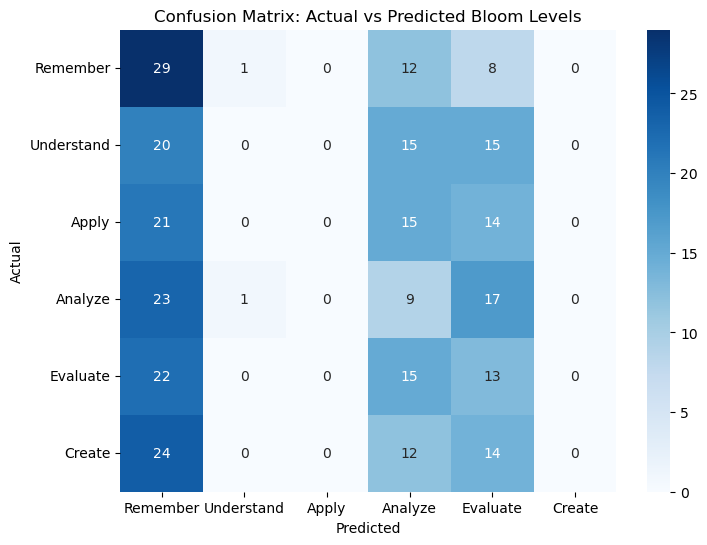

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Remember       0.12      0.18      0.14        50
  Understand       0.00      0.00      0.00        50
       Apply       0.00      0.00      0.00        50
     Analyze       0.16      0.26      0.20        50
    Evaluate       0.21      0.58      0.31        50
      Create       0.00      0.00      0.00        50

    accuracy                           0.17       300
   macro avg       0.08      0.17      0.11       300
weighted avg       0.08      0.17      0.11       300



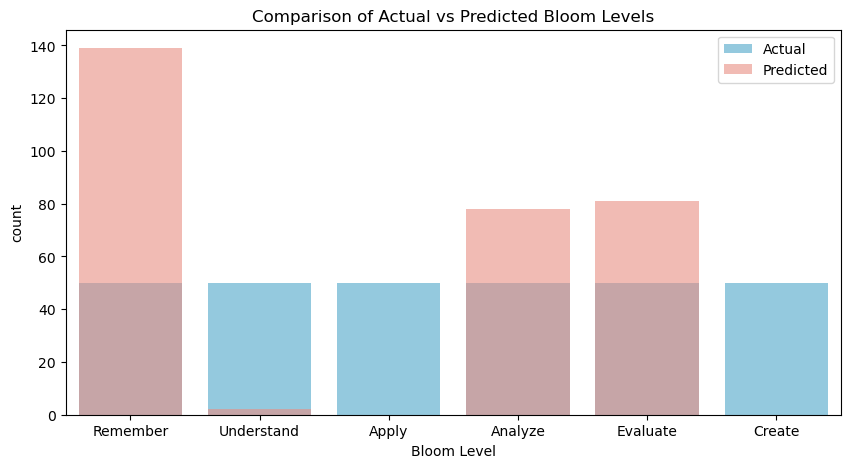

In [22]:


# Confusion matrix
cm = confusion_matrix(df[actual_col], df[pred_col], labels=bloom_order)
cm_df = pd.DataFrame(cm, index=bloom_order, columns=bloom_order)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Actual vs Predicted Bloom Levels")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification report (text output)
print(classification_report(df[actual_col], df[pred_col], target_names=bloom_order))

# Side-by-side bar plot of counts
plt.figure(figsize=(10,5))
sns.countplot(x=actual_col, data=df, order=bloom_order, color="skyblue", label="Actual")
sns.countplot(x=pred_col, data=df, order=bloom_order, color="salmon", alpha=0.6, label="Predicted")
plt.title("Comparison of Actual vs Predicted Bloom Levels")
plt.legend()
plt.show()
